In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


In [2]:
! ls ../../kaggle/ubantu_save_model

ls: cannot access '../../kaggle/ubantu_save_model': No such file or directory


'dx' is short for diagnosis (for the patient)
- 'nv': 'Melanocytic nevi'
- 'mel': 'Melanoma'
- 'bkl': 'Benign keratosis-like lesions'
- 'bcc': 'Basal cell carcinoma'
- 'akiec': 'Actinic keratoses'
- 'vasc': 'Vascular lesions'
- 'df': 'Dermatofibroma'

'dx_type' is how the diagnosis was made. 
- histo        5340
- follow_up    3704
- consensus     902
- confocal       69

In [3]:
import pandas as pd

labels_path = "../../kaggle/input/HAM10000_metadata.csv"
image_labels_df = pd.read_csv(labels_path)
image_labels_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
image_labels_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [5]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

def disease_to_label(l):
    if l == "akiec":
        return 0
    if l == "bcc":
        return 1
    if l == "bkl":
        return 2
    if l == "df":
        return 3
    if l == "mel":
        return 4
    if l == "nv":
        return 5
    if l == "vasc":
        return 6 


In [7]:
class SkinCancerDetection_train(Dataset):
    
    def __init__(self, train_path, csv, transform=None):
        self.train_path = train_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+25306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        p = os.path.join(self.train_path, image_file_name)

        img = plt.imread(p)


        if self.transform:
            img = self.transform(img)
        
        return img, label
    
class SkinCancerDetection_test(Dataset):
    
    def __init__(self, test_path, csv, transform=None):
        self.test_path = test_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+24306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        
        p = os.path.join(self.test_path, image_file_name)
        
        img = plt.imread(p)
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [8]:
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            transforms.RandomErasing(p=0.1, value='random')
        ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD) # imagenet means
])

train_ds = SkinCancerDetection_train('../../kaggle/input/HAM10000_images_train_9000','../../kaggle/input/HAM10000_metadata_train_9000.csv',transform=train_transform)
val_ds = SkinCancerDetection_test('../../kaggle/input/HAM10000_images_test_1000','../../kaggle/input/HAM10000_metadata_test_1000.csv',transform=test_transform)

## Split train and validation dataset
- batch_size = 64 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


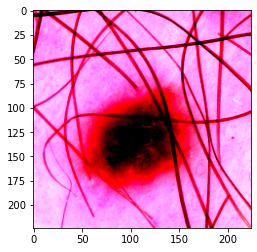

tensor(5)


In [9]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

# batch_size = 128
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

plt.figure()

for image, label in train_dl:
    plt.imshow(image[0].permute(2, 1, 0))
    print(type(image[0]))
    plt.show()
    print(label[0])
    break

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [11]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [12]:
deit_tiny_patch16_224 = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in /home/jujie/.cache/torch/hub/facebookresearch_deit_main


In [13]:
# model = to_device(ResNet9(3, 7), device)
model = to_device(deit_tiny_patch16_224, device)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Ide

In [14]:
from sklearn.metrics import precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def training_step(criterion, model,batch):
    images, labels = batch 
    
#     -------- We gonna use LabelSmoothingCrossEntropy instead of cross entropy ---------
    out = model(images)                  # Generate predictions
    loss = criterion(out, labels)  # criterion is already to device GPU

    return loss

def validation_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions

    loss = criterion(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy (return a tensor)
    
#     ------------------- calculate fscore for each batch ----------------
    
    _, y_preds = torch.max(out, dim=1)    
    threeMetrics = precision_recall_fscore_support(torch.Tensor.cpu(labels), torch.Tensor.cpu(y_preds), average=None,labels=[i for i in range(7)])
    fscore = torch.tensor(threeMetrics[2]) # fscore (return a tensor of a list: tensor([1,2,3]))

    return {'val_loss': loss.detach(), 'val_acc': acc, 'val_fscore': fscore}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs] 
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses (mean loss for n batches)
    
    batch_accs = [x['val_acc'] for x in outputs]   # [ each element is a tensor ]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies (mean acc for n batches)
    
    batch_fscores = [x['val_fscore'] for x in outputs] 
    epoch_fscore = torch.stack(batch_fscores).mean(0)

    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_fscore': epoch_fscore.tolist()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_fscore: {} ".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_fscore']))

In [15]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8, weight_decay=0.05)

In [16]:
@torch.no_grad()
def evaluate(criterion, model, val_loader):
    model.eval()
    outputs = [validation_step(criterion, model, batch) for batch in val_loader]
    return validation_epoch_end(outputs) # outputs = []

def fit_one_cycle(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    torch.cuda.empty_cache()
    history = []
    
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = training_step(criterion,model,batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            sched.step()
        
        # Validation phase
        result = evaluate(criterion, model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
history = [evaluate(criterion, model, valid_dl)]
history

[{'val_loss': 5.314132213592529,
  'val_acc': 0.04897836595773697,
  'val_fscore': [0.0, 0.0, 0.0, 0.0, 0.0, 0.1265097366019377, 0.0]}]

In [19]:
num_epochs=8
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.8912, val_loss: 1.7219, val_acc: 0.7233, val_fscore: [0.04166666666666667, 0.11765873015873016, 0.3441663595262666, 0.0, 0.11577380952380951, 0.8560410422145477, 0.0] 
Epoch [1], train_loss: 1.6616, val_loss: 1.6019, val_acc: 0.7671, val_fscore: [0.19682539682539685, 0.43442460317460313, 0.5347585556431448, 0.0, 0.2225826869209222, 0.8944762734456253, 0.6416666666666666] 
Epoch [2], train_loss: 1.5784, val_loss: 1.6039, val_acc: 0.7685, val_fscore: [0.041666666666666664, 0.5171636937941285, 0.2850933423301844, 0.175, 0.42249103870957416, 0.8859271874125504, 0.6458333333333333] 
Epoch [3], train_loss: 1.5137, val_loss: 1.4748, val_acc: 0.8206, val_fscore: [0.06944444444444445, 0.6938146997929606, 0.593429283257531, 0.29166666666666663, 0.4660450946206095, 0.9122172938522026, 0.875] 
Epoch [4], train_loss: 1.4814, val_loss: 1.4665, val_acc: 0.8183, val_fscore: [0.30833333333333335, 0.6664141414141413, 0.6163442460317461, 0.41666666666666663, 0.41065884042857725, 

In [20]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.3562, val_loss: 1.4996, val_acc: 0.8047, val_fscore: [0.12142857142857144, 0.6262061403508772, 0.6114335449033724, 0.16666666666666666, 0.5429727055868029, 0.9169832543699172, 0.5208333333333333] 
Epoch [1], train_loss: 1.3442, val_loss: 1.4559, val_acc: 0.8223, val_fscore: [0.4645021645021645, 0.7100139626455415, 0.5931973964732585, 0.37499999999999994, 0.48086737394012935, 0.9026485837821798, 0.5833333333333333] 
Epoch [2], train_loss: 1.3125, val_loss: 1.4824, val_acc: 0.8190, val_fscore: [0.31845238095238093, 0.6824817726133516, 0.6186631530624856, 0.29166666666666663, 0.3115575396825397, 0.9154557796189062, 0.6416666666666666] 
Epoch [3], train_loss: 1.2867, val_loss: 1.4314, val_acc: 0.8507, val_fscore: [0.4017857142857143, 0.7495421245421245, 0.6685873830080219, 0.41666666666666663, 0.6199906301267463, 0.9295440981632591, 0.725] 


In [21]:
num_epochs=2
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.2672, val_loss: 1.4742, val_acc: 0.8314, val_fscore: [0.4683802308802309, 0.7514072732822732, 0.6061000120984641, 0.5238095238095238, 0.5616974399869137, 0.9214164921415222, 0.875] 
Epoch [1], train_loss: 1.2504, val_loss: 1.5087, val_acc: 0.7906, val_fscore: [0.35232267732267736, 0.6933621933621934, 0.5824137651115346, 0.46111111111111114, 0.48519814877321665, 0.8926720562033508, 0.8125] 


In [22]:
# torch.save(model.state_dict(), 'deit_tiny_patch16_224.pth')
torch.save(model.state_dict(), '../../kaggle/ubuntu_save_model/ubuntu_sourceCode_size91_deit_tiny_patch16_224.pth')

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

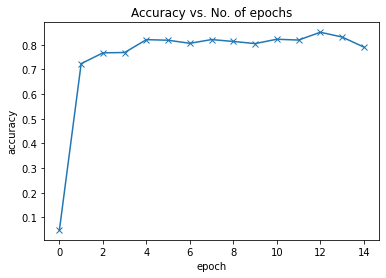

In [24]:
plot_accuracies(history)

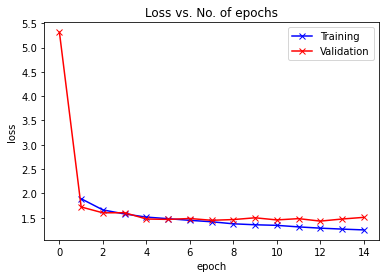

In [25]:
plot_losses(history)